# Computational Data Mining - Project 2

### Objectives
*   **Linearity Analysis**: Understanding independence and collinearity.
*   **Feature Engineering**: Implementing PCA (Extraction) and SelectKBest/RFE (Selection).
*   **Model Analysis**: Evaluating stability and convergence in different feature spaces.
*   **Optimization Comparison**: Derivative-based vs. Iterative approaches.

### Data Sources
1.  **Classification**: Breast Cancer dataset.
2.  **Regression**: Boston Housing dataset.
3.  **Clustering**: Iris dataset.

## Section 1: Library Imports & Configuration
Importing necessary libraries for data manipulation, visualization, and machine learning. Setting global seeds for reproducibility.

In [1]:
# -- System & Utilities --
import time
from dataclasses import dataclass
from typing import Dict, List, Optional

# -- Data Processing --
import numpy as np
import pandas as pd

# -- Visualization --
import matplotlib.pyplot as plt

# -- Scikit-Learn: Core & Preprocessing --
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted

# -- Scikit-Learn: Metrics --
from sklearn.metrics import mean_squared_error, accuracy_score, silhouette_score

# -- Scikit-Learn: Feature Engineering --
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, RFE, f_regression, f_classif

# -- Scikit-Learn: Models --
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# -- Scikit-Learn: Datasets --
from sklearn.datasets import load_breast_cancer, load_iris

# -- Global Configuration --
SEED_VAL = 2020
np.random.seed(SEED_VAL)

## Section 2: Utility Functions & Classes
Defining helper classes and functions for:
*   Tracking model training and evaluation time.
*   Visualizing matrices (heatmaps).
*   Plotting PCA explained variance.

In [2]:
@dataclass
class TrainingResult:
    """
    Container for model performance metrics.
    """
    duration_fit: float
    duration_score: float
    performance_metric: float
    metadata: Dict

def execute_and_time_model(estimator, X_tr, y_tr, X_te=None, y_te=None, metric_type='auto'):
    """
    Fits the estimator and evaluates it, tracking execution time.
    """
    # 1. Training
    start_fit = time.perf_counter()
    if y_tr is not None:
        estimator.fit(X_tr, y_tr)
    else:
        estimator.fit(X_tr)
    end_fit = time.perf_counter()
    
    # 2. Evaluation
    start_score = time.perf_counter()
    score_val = None
    
    if X_te is not None and y_te is not None:
        if metric_type == 'mse':
            preds = estimator.predict(X_te)
            score_val = mean_squared_error(y_te, preds)
        elif metric_type == 'accuracy':
            preds = estimator.predict(X_te)
            score_val = accuracy_score(y_te, preds)
        else:
            score_val = estimator.score(X_te, y_te)
            
    end_score = time.perf_counter()
    
    return TrainingResult(
        duration_fit=end_fit - start_fit,
        duration_score=end_score - start_score,
        performance_metric=score_val,
        metadata={}
    )

def show_heatmap(data_matrix, chart_title, x_labels=None, y_labels=None):
    """
    Generates a heatmap for the provided matrix.
    """
    plt.figure(figsize=(6, 5))
    ax = plt.gca()
    
    img = ax.imshow(data_matrix, cmap='coolwarm', interpolation='nearest')
    ax.set_title(chart_title)
    
    if x_labels is not None:
        ax.set_xticks(range(len(x_labels)))
        ax.set_xticklabels(x_labels, rotation=80, ha='right', fontsize=8)
        
    if y_labels is not None:
        ax.set_yticks(range(len(y_labels)))
        ax.set_yticklabels(y_labels, fontsize=8)
        
    plt.colorbar(img, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def plot_cumulative_variance(pca_obj, chart_title="PCA: Explained Variance"):
    """
    Plots the cumulative explained variance ratio.
    """
    plt.figure(figsize=(6, 4))
    
    cumulative_var = np.cumsum(pca_obj.explained_variance_ratio_)
    indices = range(1, len(cumulative_var) + 1)
    
    plt.plot(indices, cumulative_var, marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Cumulative Variance")
    plt.title(chart_title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## Section 3: Data Ingestion
Loading the three datasets used in this project:
1.  **Breast Cancer** (Classification)
2.  **Boston Housing** (Regression)
3.  **Iris** (Clustering)

In [3]:
# 1. Breast Cancer Data (Classification)
raw_cancer = load_breast_cancer(as_frame=True)
feat_cancer = raw_cancer.data.copy()
target_cancer = raw_cancer.target.copy()
cols_cancer = feat_cancer.columns.tolist()

# 2. Boston Housing Data (Regression)
housing_cols = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE',
    'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]
raw_housing = pd.read_csv(
    'BostonHousing.csv', 
    header=None, 
    delimiter=r"\s+", 
    names=housing_cols
)

feat_housing = raw_housing.drop(columns=['MEDV']).copy()
target_housing = raw_housing['MEDV'].copy()
cols_housing = feat_housing.columns.tolist()

# 3. Iris Data (Clustering)
raw_iris = load_iris(as_frame=True)
feat_iris = raw_iris.data.copy()
cols_iris = feat_iris.columns.tolist()

print(f"Dataset Dimensions:\n"
      f" - Classification: {feat_cancer.shape}\n"
      f" - Regression:     {feat_housing.shape}\n"
      f" - Clustering:     {feat_iris.shape}")

Dataset Dimensions:
 - Classification: (569, 30)
 - Regression:     (506, 13)
 - Clustering:     (150, 4)


## Section 4: Covariance Inspection
Analyzing the relationships between features in each dataset using Covariance Matrices and Heatmaps.

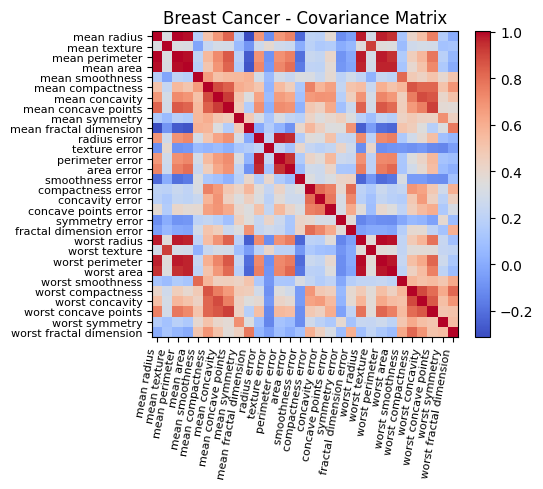

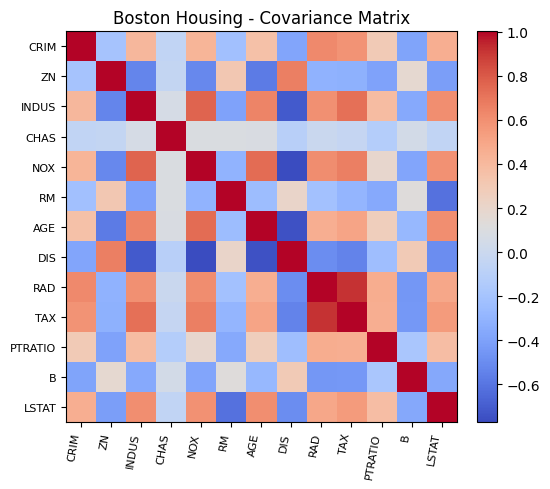

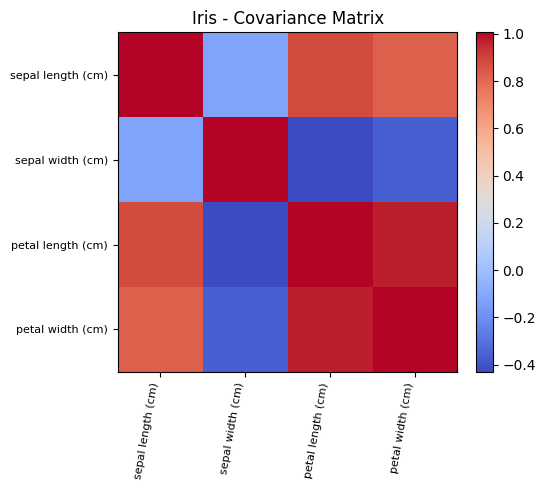

In [4]:
def calc_covariance_heatmap(df_features, label):
    """
    Standardizes data and plots the covariance matrix.
    """
    # Standardization (Z-score)
    df_std = (df_features - df_features.mean()) / df_features.std(ddof=0)
    
    # Covariance calculation
    cov_mat = np.cov(df_std.values, rowvar=False)
    
    # Visualization
    show_heatmap(
        cov_mat, 
        chart_title=f"{label} - Covariance Matrix", 
        x_labels=df_features.columns, 
        y_labels=df_features.columns
    )
    return cov_mat

# Execute for all datasets
cov_mat_cancer = calc_covariance_heatmap(feat_cancer, "Breast Cancer")
cov_mat_housing = calc_covariance_heatmap(feat_housing, "Boston Housing")
cov_mat_iris = calc_covariance_heatmap(feat_iris, "Iris")

## Section 5: Dimensionality Reduction (PCA)
Applying Principal Component Analysis (PCA) to reduce the dimensionality of the datasets while retaining 90% of the variance.

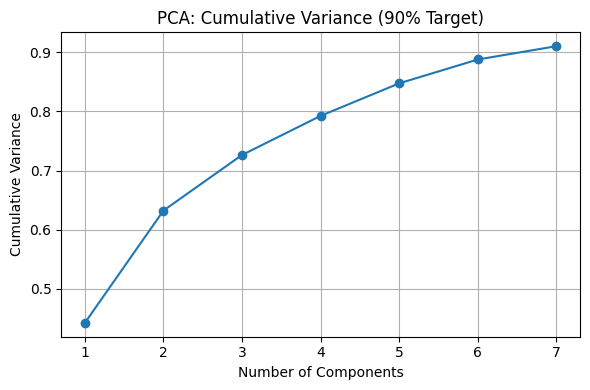

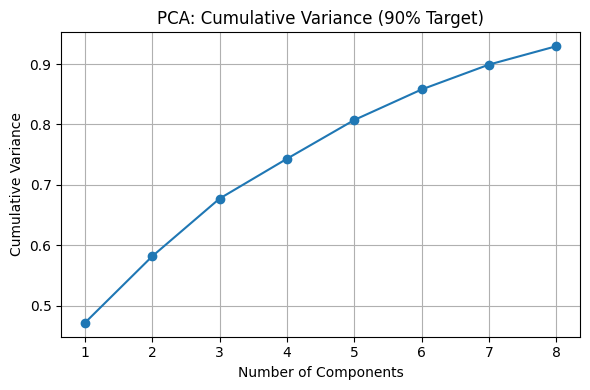

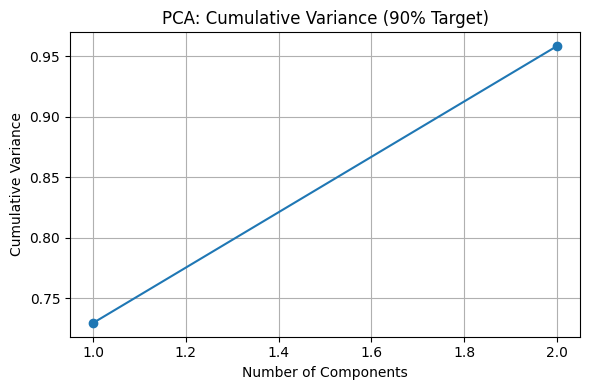

Retained Components:
 - Cancer:  7
 - Housing: 8
 - Iris:    2


In [5]:
def run_pca_90_variance(df_in):
    """
    Applies PCA retaining 90% of variance after standardization.
    """
    scaler_obj = StandardScaler()
    data_scaled = scaler_obj.fit_transform(df_in)
    
    # PCA with 0.9 explained variance threshold
    pca_obj = PCA(n_components=0.9, random_state=SEED_VAL)
    data_pca = pca_obj.fit_transform(data_scaled)
    
    plot_cumulative_variance(pca_obj, chart_title="PCA: Cumulative Variance (90% Target)")
    
    return data_pca, pca_obj, scaler_obj

# Apply PCA
feat_cancer_pca, pca_model_cancer, scaler_cancer = run_pca_90_variance(feat_cancer)
feat_housing_pca, pca_model_housing, scaler_housing = run_pca_90_variance(feat_housing)
feat_iris_pca, pca_model_iris, scaler_iris = run_pca_90_variance(feat_iris)

print(f"Retained Components:\n"
      f" - Cancer:  {feat_cancer_pca.shape[1]}\n"
      f" - Housing: {feat_housing_pca.shape[1]}\n"
      f" - Iris:    {feat_iris_pca.shape[1]}")

## Section 6: Feature Selection Strategies
Selecting the most important features using:
*   **SelectKBest**: Univariate feature selection.
*   **RFE (Recursive Feature Elimination)**: Wrapper method using an estimator.
The number of selected features is set to match the number of components retained by PCA.

In [6]:
# Target feature count matches PCA results
n_feats_cancer = feat_cancer_pca.shape[1]
n_feats_housing = feat_housing_pca.shape[1]

# 1. SelectKBest (Classification)
pipe_skb_cancer = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=n_feats_cancer))
])
feat_cancer_skb = pipe_skb_cancer.fit_transform(feat_cancer, target_cancer)

# 2. SelectKBest (Regression)
pipe_skb_housing = Pipeline([
    ('scale', StandardScaler()),
    ('select', SelectKBest(score_func=f_regression, k=n_feats_housing))
])
feat_housing_skb = pipe_skb_housing.fit_transform(feat_housing, target_housing)

# 3. RFE (Regression) - Linear Base
base_rfe_reg = LinearRegression()
pipe_rfe_housing = Pipeline([
    ('scale', StandardScaler()),
    ('rfe', RFE(estimator=base_rfe_reg, n_features_to_select=n_feats_housing))
])
feat_housing_rfe = pipe_rfe_housing.fit_transform(feat_housing, target_housing)

# 4. RFE (Classification) - RandomForest Base
base_rfe_cls = RandomForestClassifier(n_estimators=200, random_state=SEED_VAL, n_jobs=-1)
pipe_rfe_cancer = Pipeline([
    ('scale', StandardScaler()),
    ('rfe', RFE(estimator=base_rfe_cls, n_features_to_select=n_feats_cancer, step=0.2))
])
feat_cancer_rfe = pipe_rfe_cancer.fit_transform(feat_cancer, target_cancer)

print(f"Feature Selection Output Shapes:\n"
      f" - Cancer (SKB / RFE): {feat_cancer_skb.shape} / {feat_cancer_rfe.shape}\n"
      f" - Housing (SKB / RFE): {feat_housing_skb.shape} / {feat_housing_rfe.shape}")

Feature Selection Output Shapes:
 - Cancer (SKB / RFE): (569, 7) / (569, 7)
 - Housing (SKB / RFE): (506, 8) / (506, 8)


## Section 7: Regression Analysis (Linear)
Comparing **Linear Regression** performance on:
1.  Original Features
2.  PCA-Transformed Features
Analyzing Mean Squared Error (MSE), training time, and coefficient magnitudes.

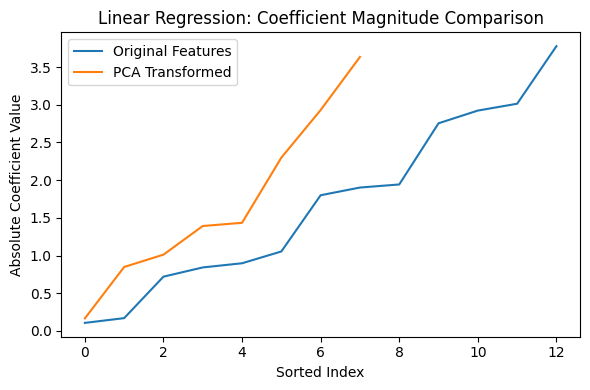

Linear Regression Results:
 - Full Features: MSE=20.6048, Time=0.0027s
 - PCA Features:  MSE=24.6336, Time=0.0024s


In [7]:
# Split Data
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    feat_housing, target_housing, 
    test_size=0.25, 
    random_state=SEED_VAL
)

# Model 1: Linear Regression (Full Features)
model_lin_full = Pipeline([
    ('scale', StandardScaler()),
    ('regressor', LinearRegression())
])

# Model 2: Linear Regression (PCA Features)
model_lin_pca = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=pca_model_housing.n_components_, random_state=SEED_VAL)),
    ('regressor', LinearRegression())
])

# Execution
res_lin_full = execute_and_time_model(model_lin_full, X_train_h, y_train_h, X_test_h, y_test_h, metric_type='mse')
res_lin_pca = execute_and_time_model(model_lin_pca, X_train_h, y_train_h, X_test_h, y_test_h, metric_type='mse')

# Coefficient Analysis
def extract_coeffs(pipe):
    try:
        reg = pipe.named_steps['regressor']
        check_is_fitted(reg)
        return reg.coef_.ravel()
    except:
        return None

coeffs_full = extract_coeffs(model_lin_full)
coeffs_pca = extract_coeffs(model_lin_pca)

if coeffs_full is not None and coeffs_pca is not None:
    plt.figure(figsize=(6, 4))
    plt.plot(sorted(np.abs(coeffs_full)), label='Original Features')
    plt.plot(sorted(np.abs(coeffs_pca)), label='PCA Transformed')
    plt.title('Linear Regression: Coefficient Magnitude Comparison')
    plt.xlabel('Sorted Index')
    plt.ylabel('Absolute Coefficient Value')
    plt.legend()
    plt.tight_layout()
    plt.show()

print(f"Linear Regression Results:\n"
      f" - Full Features: MSE={res_lin_full.performance_metric:.4f}, Time={res_lin_full.duration_fit:.4f}s\n"
      f" - PCA Features:  MSE={res_lin_pca.performance_metric:.4f}, Time={res_lin_pca.duration_fit:.4f}s")

## Section 8: SGD Regression Analysis
Comparing **Stochastic Gradient Descent (SGD) Regressor** performance on Original vs. PCA features.
Focusing on convergence speed (iterations) and MSE.

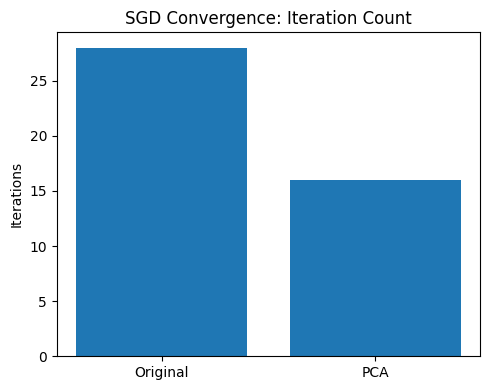

SGD Results:
 - Full: MSE=20.8808, Iterations=28
 - PCA:  MSE=24.7824, Iterations=16


In [8]:
# SGD Configuration
sgd_params = {
    'random_state': SEED_VAL,
    'max_iter': 2000,
    'tol': 1e-3,
    'learning_rate': 'invscaling',
    'eta0': 0.01
}

# Model 1: SGD (Full)
model_sgd_full = Pipeline([
    ('scale', StandardScaler()),
    ('sgd', SGDRegressor(**sgd_params))
])

# Model 2: SGD (PCA)
model_sgd_pca = Pipeline([
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=pca_model_housing.n_components_, random_state=SEED_VAL)),
    ('sgd', SGDRegressor(**sgd_params))
])

# Execution
res_sgd_full = execute_and_time_model(model_sgd_full, X_train_h, y_train_h, X_test_h, y_test_h, metric_type='mse')
res_sgd_pca = execute_and_time_model(model_sgd_pca, X_train_h, y_train_h, X_test_h, y_test_h, metric_type='mse')

# Convergence Check
def get_iterations(pipe):
    try:
        est = pipe.named_steps['sgd']
        check_is_fitted(est)
        return est.n_iter_
    except:
        return 0

iters_full = get_iterations(model_sgd_full)
iters_pca = get_iterations(model_sgd_pca)

# Visualization
plt.figure(figsize=(5, 4))
plt.bar(['Original', 'PCA'], [iters_full, iters_pca])
plt.title('SGD Convergence: Iteration Count')
plt.ylabel('Iterations')
plt.tight_layout()
plt.show()

print(f"SGD Results:\n"
      f" - Full: MSE={res_sgd_full.performance_metric:.4f}, Iterations={iters_full}\n"
      f" - PCA:  MSE={res_sgd_pca.performance_metric:.4f}, Iterations={iters_pca}")

## Section 9: Clustering Analysis (K-Means)
Evaluating **K-Means Clustering** on the Iris dataset.
Comparing clustering quality (Inertia, Silhouette Score) and speed on raw data vs. PCA-reduced data.

Clusters: 2 | Std: Inertia=152.35, Sil=0.681, Time=1.4542s || PCA: Inertia=137.16, Sil=0.706, Time=0.0203s


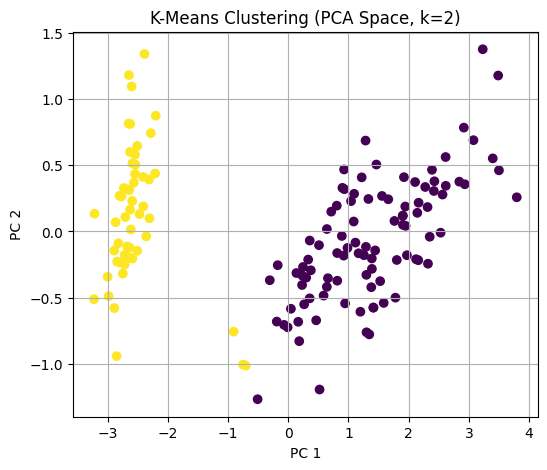

Clusters: 3 | Std: Inertia=78.85, Sil=0.553, Time=0.0357s || PCA: Inertia=63.82, Sil=0.598, Time=0.0172s


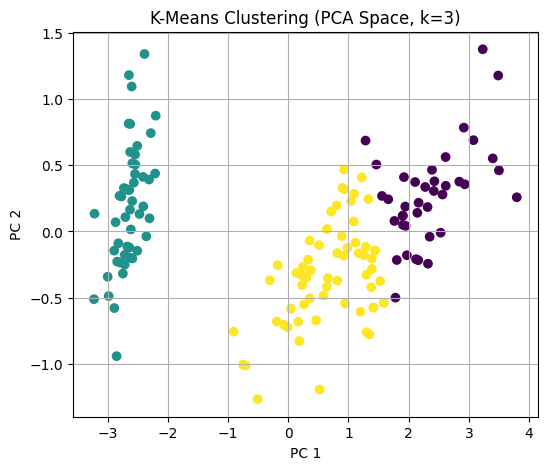

In [9]:
cluster_counts = [2, 3]

for k_val in cluster_counts:
    # 1. Standard K-Means
    kmeans_std = KMeans(n_clusters=k_val, n_init=20, random_state=SEED_VAL)
    
    t_start = time.perf_counter()
    kmeans_std.fit(feat_iris)
    t_std = time.perf_counter() - t_start
    
    metric_inertia_std = kmeans_std.inertia_
    metric_sil_std = silhouette_score(feat_iris, kmeans_std.labels_)
    metric_iter_std = kmeans_std.n_iter_
    
    # 2. PCA K-Means (2D)
    pca_2d_obj = PCA(n_components=min(2, feat_iris_pca.shape[1]), random_state=SEED_VAL)
    feat_iris_2d = pca_2d_obj.fit_transform(feat_iris)
    
    kmeans_pca = KMeans(n_clusters=k_val, n_init=10, random_state=SEED_VAL)
    
    t_start = time.perf_counter()
    kmeans_pca.fit(feat_iris_2d)
    t_pca = time.perf_counter() - t_start
    
    metric_inertia_pca = kmeans_pca.inertia_
    metric_sil_pca = silhouette_score(feat_iris_2d, kmeans_pca.labels_)
    metric_iter_pca = kmeans_pca.n_iter_
    
    print(f"Clusters: {k_val} | "
          f"Std: Inertia={metric_inertia_std:.2f}, Sil={metric_sil_std:.3f}, Time={t_std:.4f}s || "
          f"PCA: Inertia={metric_inertia_pca:.2f}, Sil={metric_sil_pca:.3f}, Time={t_pca:.4f}s")
          
    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(feat_iris_2d[:, 0], feat_iris_2d[:, 1], c=kmeans_pca.labels_, cmap='viridis')
    plt.title(f"K-Means Clustering (PCA Space, k={k_val})")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.show()

## Section 10: Classification Benchmarks
Benchmarking **KNN** and **Random Forest** classifiers on the Breast Cancer dataset.
Comparing three scenarios:
1.  Baseline (All features)
2.  PCA Features
3.  SelectKBest Features

In [10]:
# Split Data
X_tr_c, X_val_c, y_tr_c, y_val_c = train_test_split(
    feat_cancer, target_cancer,
    test_size=0.15,
    random_state=SEED_VAL,
    stratify=target_cancer
)

# --- KNN Experiments ---
def run_knn_experiments():
    exp_data = []
    
    # 1. Baseline
    pipe_base = Pipeline([
        ('scale', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    
    t0 = time.perf_counter()
    pipe_base.fit(X_tr_c, y_tr_c)
    t_fit = time.perf_counter() - t0
    
    t1 = time.perf_counter()
    preds = pipe_base.predict(X_val_c)
    t_pred = time.perf_counter() - t1
    
    exp_data.append(("Baseline", accuracy_score(y_val_c, preds), t_fit, t_pred))
    
    # 2. PCA
    pipe_pca = Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=pca_model_cancer.n_components_, random_state=SEED_VAL)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    
    t0 = time.perf_counter()
    pipe_pca.fit(X_tr_c, y_tr_c)
    t_fit = time.perf_counter() - t0
    
    t1 = time.perf_counter()
    preds = pipe_pca.predict(X_val_c)
    t_pred = time.perf_counter() - t1
    
    exp_data.append(("PCA", accuracy_score(y_val_c, preds), t_fit, t_pred))
    
    # 3. SelectKBest
    pipe_skb = Pipeline([
        ('scale', StandardScaler()),
        ('skb', SelectKBest(score_func=f_classif, k=pca_model_cancer.n_components_)),
        ('knn', KNeighborsClassifier(n_neighbors=5))
    ])
    
    t0 = time.perf_counter()
    pipe_skb.fit(X_tr_c, y_tr_c)
    t_fit = time.perf_counter() - t0
    
    t1 = time.perf_counter()
    preds = pipe_skb.predict(X_val_c)
    t_pred = time.perf_counter() - t1
    
    exp_data.append(("SelectKBest", accuracy_score(y_val_c, preds), t_fit, t_pred))
    
    return exp_data

# --- RandomForest Experiments ---
def run_rf_experiments():
    exp_data = []
    rf_model = RandomForestClassifier(n_estimators=200, random_state=SEED_VAL, n_jobs=-1)
    
    # 1. Baseline
    pipe_base = Pipeline([('scale', StandardScaler()), ('rf', rf_model)])
    res_base = execute_and_time_model(pipe_base, X_tr_c, y_tr_c, X_val_c, y_val_c, metric_type='accuracy')
    exp_data.append(("Baseline", res_base.performance_metric, res_base.duration_fit, res_base.duration_score))
    
    # 2. PCA
    pipe_pca = Pipeline([
        ('scale', StandardScaler()), 
        ('pca', PCA(n_components=pca_model_cancer.n_components_, random_state=SEED_VAL)),
        ('rf', rf_model)
    ])
    res_pca = execute_and_time_model(pipe_pca, X_tr_c, y_tr_c, X_val_c, y_val_c, metric_type='accuracy')
    exp_data.append(("PCA", res_pca.performance_metric, res_pca.duration_fit, res_pca.duration_score))
    
    # 3. SelectKBest
    pipe_skb = Pipeline([
        ('scale', StandardScaler()),
        ('skb', SelectKBest(score_func=f_classif, k=pca_model_cancer.n_components_)),
        ('rf', rf_model)
    ])
    res_skb = execute_and_time_model(pipe_skb, X_tr_c, y_tr_c, X_val_c, y_val_c, metric_type='accuracy')
    exp_data.append(("SelectKBest", res_skb.performance_metric, res_skb.duration_fit, res_skb.duration_score))
    
    return exp_data

# Execution & Display
df_knn = pd.DataFrame(run_knn_experiments(), columns=["Method", "Accuracy", "Train Time", "Infer Time"])
df_rf = pd.DataFrame(run_rf_experiments(), columns=["Method", "Accuracy", "Train Time", "Infer Time"])

display("KNN Performance Summary", df_knn)
display("RandomForest Performance Summary", df_rf)

'KNN Performance Summary'

,Method,Accuracy,Train Time,Infer Time
0,Baseline,0.965116,0.002440,0.004562
1,PCA,0.965116,0.002372,0.001677
2,SelectKBest,0.930233,0.002212,0.001504


'RandomForest Performance Summary'

,Method,Accuracy,Train Time,Infer Time
0,Baseline,0.953488,0.165209,0.029621
1,PCA,0.965116,0.165883,0.027224
2,SelectKBest,0.918605,0.174397,0.026946
